In [1]:
# -*- coding: utf-8 -*-
"""
@author: Shoichi Hirooka 

データクリーニングを行いPLS解析を行う．
CrossValidationを実施して主軸の最適化を実施．
PLSモデルを決定する．
VIPを計算し、VIP >= 0.8 の説明変数に絞り込みを行う．
絞り込んだ説明変数を用いてPLSを再実行
CrossValidationのr2cv値が最大となる説明変数の量を探す．

"""

'\n@author: Shoichi Hirooka \n\nデータクリーニングを行いPLS解析を行う．\nCrossValidationを実施して主軸の最適化を実施．\nPLSモデルを決定する．\nVIPを計算し、VIP >= 0.8 の説明変数に絞り込みを行う．\n絞り込んだ説明変数を用いてPLSを再実行\nCrossValidationのr2cv値が最大となる説明変数の量を探す．\n\n'

In [2]:
%matplotlib inline

In [3]:
import matplotlib.figure as figure
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn import model_selection
from sklearn.cross_decomposition import PLSRegression
import pickle

In [4]:
max_pls_component_number = 50
fold_number = 5
threshold_of_rate_of_same_value = 0.79
threshold_of_multico = 0.9
do_autoscaling = True  # True or False

In [5]:
def load_csv_data(csv_file, index_col=0):
    """
    データの読み込みを行う
    input : csv_fil          string
            index_col = 0    int    
    output: raw_data_with_y  pandas.DataFrame()
    
    """
    raw_data_with_y = pd.read_csv(csv_file, encoding='SHIFT-JIS', index_col=index_col)
    return raw_data_with_y

In [6]:
def split_train_test(raw_data_with_y):
    """
    yの値があるか、ないかで訓練用データ（ｙ有り）と予測用データ（ｙ無し）に分ける．
    input : raw_data_with_y pd.DataFrame 1行目が y（目的変数）の値
  
    output: train_data　pd.DataFrame yの値がわかっているデータ
            test_data   pd.DataFrame yの値が不明の今後の予測用データ .iloc[:,0]はnp.nanとなっている
    """
    train_data = raw_data_with_y[pd.notnull(raw_data_with_y.iloc[:,0])]
    test_data  = raw_data_with_y[pd.isnull(raw_data_with_y.iloc[:,0])]
    
    return train_data, test_data

In [7]:
def drop_np_nan(raw_data_with_y):
    """
    平均値を計算できる変数列を選択し、
    np.infはnp.nanに変換して 欠損値にnp.nanを埋める．
    np.nanが存在する列（axis=1)を削除する df.dropna().
    
    input : raw_data_with_y pd.DataFrame
    output: raw_data_wtih_y pd.DataFrame
        
    """
    # 平均を計算できる変数だけ選択
    raw_data_with_y = raw_data_with_y.loc[:, raw_data_with_y.mean().index]
    
    # infをnanに置き換えておく
    raw_data_with_y = raw_data_with_y.replace(np.inf, np.nan).fillna(np.nan)
    
    # nanのある変数を削除
    raw_data_with_y = raw_data_with_y.dropna(axis=1)  
    
    return raw_data_with_y

In [8]:
def delete_duplicates(raw_data_with_y):
    """
    重複データを削除する 
    df.duplicated()を使い重複データの抽出．
    keep=Falseの場合 raw_data_with_y.indexに重複がある場合はすべて削除している．
    
    input: raw_data_with_y
    
    output: raw_data_with_y
    
    """
    # 重複したサンプルはすべて削除
    raw_data_with_y = raw_data_with_y.loc[~raw_data_with_y.index.duplicated(keep=False), :]  
    
    #重複したサンプルの最初を残す場合
    # raw_data_with_y = raw_data_with_y.loc[~raw_data_with_y.index.duplicated(keep='first'),:]
    
    #重複したサンプルの最後を残す場合
    # raw_data_with_y = raw_data_with_y.loc[~raw_data_with_y.index.duplicated(keep='last'),:] 
    
    return raw_data_with_y

In [9]:
def split_y_rawX(raw_data_with_y):
    """
    y     目的変数の列を１列目 　　　　　　　　df.columns[0]で抽出
    rawX  2列目以降はすべて説明変数として抽出　df.columns[1:]
    
    input  : raw_data_with_y
    
    output : y
             rawX    
    """   
    #ｙとして1列目を指定
    y = raw_data_with_y[raw_data_with_y.columns[0]]  

    rawX = raw_data_with_y[raw_data_with_y.columns[1:]]  #変数は2列目以降
    
    return y, rawX

In [10]:
def delete_hrt_same_value(y, rawX, threshold_of_rate_of_same_value):
    """
    80％以上 同じ数値が繰り返されている列を
    抽出(deleting_variable_numbersとして抽出)し列ごと削除する
    閾値はthreshold_of_rate_of_same_value = 0.79で設定

    input :　y
             rawX
             threshold_of_rate_of_same_value
    
    outpu :  y
             X  
    
    """
    y = y
    
    rate_of_same_value = list()
    num = 0
    cols = rawX.columns

    for col in cols:
        num += 1
        #print('{0} / {1}'.format(num, rawX.shape[1]))
        same_value_number = rawX[col].value_counts()
        rate_of_same_value.append(float(same_value_number[same_value_number.index[0]] / rawX.shape[0]))
    
    deleting_variable_numbers = np.where(np.array(rate_of_same_value) >= threshold_of_rate_of_same_value)

    if len(deleting_variable_numbers[0]) == 0:
        X = rawX
    else:
        X = rawX.drop(rawX.columns[deleting_variable_numbers], axis=1)
        #print('Variable numbers zero variance: {0}'.format(deleting_variable_numbers[0] + 1))

    #print('# of X-variables: {0}'.format(X.shape[1]))
    
    return y, X

In [11]:
def shapiro_check(X, alpha=0.05):
    """
    正規性の確認
    Shapiro-Wilks検定で p値 が 0.05より大きければ 正規性がないと判定する
    
    """
    from scipy import stats
    cols = X.columns
    drop_col_list=[]
    col_list=[]
    for col in cols:
        w, p = stats.shapiro(X[col])
        if p > alpha:
            drop_col_list.append(col)
        else:
            col_list.append(col)
    
    X = X[col_list] 
    
    return X, drop_col_list

In [12]:
def outlier_iqr(df):
    for i in range(len(df.columns)):
        if i == 0:
            pass
        else:
            # 列を抽出する
            col = df.iloc[:,i]

            # 四分位数
            q1 = col.describe()['25%']
            q3 = col.describe()['75%']
            iqr = q3 - q1 #四分位範囲

            # 外れ値の基準点
            outlier_min = q1 - (iqr) * 1.5
            outlier_max = q3 + (iqr) * 1.5

            # 範囲から外れている値を除く
            col[col < outlier_min] = None
            col[col > outlier_max] = None
        
    return df

In [13]:
def outlier_sigma(df,x_sigma=4.5):

    for i in range(len(df.columns)):
        if i == 0:
            pass
        else:
            # 列を抽出する
            col = df.iloc[:,i]

            # 平均と標準偏差
            average = np.mean(col)
            sd = np.std(col)

            # 外れ値の基準点
            outlier_min = average - (sd) * x_sigma
            outlier_max = average + (sd) * x_sigma

            # 範囲から外れている値を除く
            col[col < outlier_min] = None
            col[col > outlier_max] = None

    return df

In [14]:
def y_X_pearsonr(y, X):
    """
    scipy.stats ピアソンの相関係数 pearsonrを用いて 
    相関係数とp値を出力
    相関係数の絶対値が大きい順にXのColumnsを並べ替える
    
    input  :　y
              X
              
    output :  y
              X    
    """
    from scipy.stats import pearsonr
    
    dic = {}
    newdict={}
    cols = X.columns
    for string in cols:
        r2, p = pearsonr(y, X[string])
        dic[string] = np.abs(r2)
    #print(dic)
    
    for key, value in sorted(dic.items(), key=lambda x: -x[1]):
        #print(str(key) + ": " + str(value))
        newdict[key]=value
        
    col_list=[*newdict]
    X=X[col_list]
    
    return y, X

In [15]:
def multi_cov(X, threshold_of_multico):
    """
    多重共線性の確認を行い　
    X.corr()の値が0.9以上であればXのColumn 右側となるColumnを削除する．
    （先にy_X_pearsonrを使ってColumnを並び替えておくこと．）
    
    input  :X
            threshold_of_multico
           
    output : multico  多重共線性がある説明変数を削除したColumns List
             X　　　　多重共線性を取り除いた説明変数
    
    """
    X_corr=X.corr()

    n=0
    th = threshold_of_multico
    multico_list=[]

    for string1 in X_corr.columns:
        n += 1
        for string2 in X_corr.columns[n:]:
            if X_corr[string1][string2] > th :
                multico_list.append(string2)
            elif X_corr[string1][string2] < - th :
                multico_list.append(string2)

                
    multico = pd.Series(multico_list)
    multico = multico.drop_duplicates()
    
    X = X.drop(multico, axis=1)
    
    return multico, X


In [16]:
def auto_scaling(y, X, do_autoscaling):
    """
    標準化（Z変換）するのか do_autoscalingで判断し
    
    Trueの場合は標準化を行う．
    Falseの場合はそのままの状態で返す
    
    input  : y
             X
             do_autoscaling    
    output : autoscaled_y
             autoscaled_X
    
    """
    if do_autoscaling:
        autoscaled_X = (X - X.mean(axis=0)) / X.std(axis=0, ddof=1)# N-1で割り算する デフォルトddof=1なので表記しなくてもよい
        autoscaled_y = (y - y.mean()) / y.std(ddof=1)
    else:
        autoscaled_X = X
        autoscaled_y = y
    
    return autoscaled_y, autoscaled_X

In [17]:
def pls_r_cv(y, autoscaled_y, autoscaled_X, max_pls_component_number, fold_number):
    """
    PLS クロスバリデーションを実施して、
    主軸の数 optimal_pls_component_numberを求める．
    
    """
    pls_components = np.arange(1, min(np.linalg.matrix_rank(autoscaled_X) + 1, max_pls_component_number + 1), 1)
    r2all = list()
    r2cvall = list()
    
    for pls_component in pls_components:
        pls_model_in_cv = PLSRegression(n_components=pls_component)
        pls_model_in_cv.fit(autoscaled_X, autoscaled_y)
        
        calculated_y_in_cv = np.ndarray.flatten(pls_model_in_cv.predict(autoscaled_X))
        #ここでCrossValidationを行っている model_selection.cross_val_predict()
        estimated_y_in_cv = np.ndarray.flatten(
            model_selection.cross_val_predict(pls_model_in_cv, autoscaled_X, autoscaled_y, cv=fold_number))
        
        if do_autoscaling:
            calculated_y_in_cv = calculated_y_in_cv * y.std(ddof=1) + y.mean()
            estimated_y_in_cv = estimated_y_in_cv * y.std(ddof=1) + y.mean()
        
        r2all.append(float(1 - sum((y - calculated_y_in_cv) ** 2) / sum((y - y.mean()) ** 2)))
        r2cvall.append(float(1 - sum((y - estimated_y_in_cv) ** 2) / sum((y - y.mean()) ** 2)))
        
    plt.plot(pls_components, r2all, 'bo-')
    plt.plot(pls_components, r2cvall, 'ro-')
    plt.ylim(0, 1)
    plt.xlabel('Number of PLS components')
    plt.ylabel('r2(blue), r2cv(red)')
    plt.show()
    
    optimal_pls_component_number = np.where(r2cvall == np.max(r2cvall))
    optimal_pls_component_number = optimal_pls_component_number[0][0] + 1
    
    return optimal_pls_component_number

In [18]:
def pls_r(y, autoscaled_y, autoscaled_X, optimal_pls_component_number, fold_number):
    """
    最適化されたPLSの主軸を用いてPLS解析してみる
    
    """
    regression_model = PLSRegression(n_components=optimal_pls_component_number)
    
    regression_model.fit(autoscaled_X, autoscaled_y)
    
    calculated_y = np.ndarray.flatten(regression_model.predict(autoscaled_X))
   
    cross_val_y = np.ndarray.flatten(
        model_selection.cross_val_predict(regression_model, autoscaled_X, autoscaled_y, cv=fold_number))
    
    if do_autoscaling:
        calculated_y = calculated_y * y.std(ddof=1) + y.mean()
        cross_val_y = cross_val_y * y.std(ddof=1) + y.mean()
 
    # r2
    r2 = float(1 - sum((y - calculated_y) ** 2) / sum((y - y.mean()) ** 2))
    r2cv = float(1 - sum((y - cross_val_y) ** 2) / sum((y - y.mean()) ** 2))
    print("pls_r")
    print('r2: {0}, r2cv: {1}'.format(r2, r2cv))
    
    return calculated_y, cross_val_y, r2, r2cv, regression_model

In [19]:
def plot_actual_calc(y, y_hat, title_string):
    """
    実際のyと予測したyの精度を確認するため
    X軸を実際のyの値、
    予測したyの値をY軸としてグラフ化    
    """
    plt.figure(figsize=figure.figaspect(1))
    plt.scatter(y, y_hat)
    YMax = np.max(np.array([np.array(y), y_hat]))
    YMin = np.min(np.array([np.array(y), y_hat]))
    plt.plot([YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin)],
             [YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin)], 'k-')
    plt.ylim(YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin))
    plt.xlim(YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin))
    plt.title(title_string)
    plt.xlabel('Actual Y')
    plt.ylabel('Y_hat')
    plt.show()

In [20]:
def coef(regression_model, X, y):
    """
    標準化した値での係数の確認
    これでどの要素が影響度大きいかがわかる
      
    """
    standard_regression_coefficients = regression_model.coef_
    standard_regression_coefficients = pd.DataFrame(standard_regression_coefficients)
    standard_regression_coefficients.index = X.columns
    standard_regression_coefficients.columns = ['standard regression coefficient']
    
    #print(standard_regression_coefficients) 

    y_std = y.std(ddof=1)
        
    for col in X.columns:
        X_std = X[col].std(axis=0, ddof=1)
        value_a = standard_regression_coefficients.at[col,'standard regression coefficient']
        standard_regression_coefficients.at[col,'regression coefficent'] = y_std/X_std*value_a
        standard_regression_coefficients.at[col,'abs_coef'] = np.abs(value_a)
        
    standard_regression_coefficients_sort = standard_regression_coefficients.sort_values('abs_coef', ascending=False)     
    
    return standard_regression_coefficients_sort

In [21]:
def plot_trend(y, calculated_y):
    """
    トレンドグラフ化　
    
    """
    plt.figure(figsize=(16,8))
    plt.plot(y.index, y, 'bo-')
    plt.plot(y.index, calculated_y,'rv--')
    plt.title('Comparison with calculated Y')
    plt.xlabel('Wafer_ID')
    plt.ylabel('Actual_Y(blue), calculated_Y(red)')
    plt.show()

In [22]:
def vips_select(regression_model, autoscaled_X):
    """
    ViP (Variable Importance in the Projection)を計算する．
    ViPの値が 0.8以上のものを説明変数から抽出する．
    
    """
    model = regression_model

    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_

    m, p = autoscaled_X.shape
    _, h = t.shape

    vips = np.zeros((p,))

    s = np.diag(t.T @  t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

    vips_selected_list=[]
    vips_series = pd.Series(vips, index=autoscaled_X.columns)
    vips_series.to_csv('Variable Importance in the Projecttion.csv')

    #VIPが0.8以上のものを抽出する．
    vips_selected = vips_series[vips_series >= 0.8]
    vips_selected_col = vips_selected.index
    print(len(vips_selected_col),"<-抽出された-", p)

    return vips_selected_col, vips_selected

In [23]:
def autoscaling_estimated_X(X, estimate_data, do_autoscaling):
    """
    yがわかっていないが説明変数だけは存在するデータ（estimate_data)を
    PLSRegressionで使用した Xの平均値、標準偏差を用いて 標準化する．
    autoscaling　正規化  Z変換
    
    """
    if do_autoscaling:
        autoscaled_X_estimated = (estimate_data - X.mean(axis=0)) / X.std(axis=0, ddof=1)# N-1で割り算する デフォルトddof=1なので表記しなくてもよい
    else:
        autoscaled_X_estimated = estimate_data
    
    return autoscaled_X_estimated
    

In [24]:
def pls_estimate(y, autoscaled_X_estimated, regression_model):
    """
    標準化されたXを用いて今後のyの予測を行う．
    
    """
    estimated_y = np.ndarray.flatten(regression_model.predict(autoscaled_X_estimated))
    
    if do_autoscaling:
        estimated_y = estimated_y * y.std(ddof=1) + y.mean()
    
    df_estimated_y = pd.DataFrame(estimated_y)
    df_estimated_y.index = autoscaled_X_estimated.index
    df_estimated_y.columns =  ['estimated_y']
    
    return estimated_y, df_estimated_y

In [25]:
def main():
    raw_data_with_y = load_csv_data("logS_data_set_mix.csv", index_col=0)
    
    # yの値がないデータはestimate_dataとする．    
    train_data, estimate_data = split_train_test(raw_data_with_y)
    print("split_train_test")
    print(train_data.shape, estimate_data.shape)
    
    # データ・クリーニングを実施
    raw_data_with_y = drop_np_nan(train_data)
    print("drop_np_nan")
    print(raw_data_with_y.shape)
    
    raw_data_with_y = delete_duplicates(raw_data_with_y)
    print("delete_duplicates")
    print(raw_data_with_y.shape)

    y, rawX         = split_y_rawX(raw_data_with_y)
    print("split_y_rawX")
    print(y.shape, rawX.shape)
    
    y, X            = delete_hrt_same_value(y, rawX, threshold_of_rate_of_same_value)
    print("hr_same_value")
    print(y.shape, X.shape)

    X, drop_col_list = shapiro_check(X)
    print("shapiro_check")
    print(y.shape, X.shape)
    print(drop_col_list)
    
    # 単相関を確認して相関のおおきな順に並べ替えを実施．
    y, X            = y_X_pearsonr(y, X)
    print("pearsonr")
    print(y.shape, X.shape)
    
    # 多重共線性を確認して共線性のあったものは落とす．
    multico, X      = multi_cov(X, threshold_of_multico)
    print("delete_multi_cov")
    print("multico_list :",multico)
    print(y.shape, X.shape)
    
    # 1回目　PLS CV -> PLS

    autoscaled_y, autoscaled_X = auto_scaling(y, X, do_autoscaling)
    print("auto_scaling")
    print(autoscaled_y.shape, autoscaled_X.shape)
   
    print("optimal_pls_component_number after cross_varidation")
    optimal_pls_component_number = pls_r_cv(y, autoscaled_y, autoscaled_X, max_pls_component_number, fold_number)
    print("# component_number : ", optimal_pls_component_number)
    
    print("fix_regression_model")
    calcurate_y, cross_val_y, r2, r2cv, regression_model= pls_r(y, autoscaled_y, autoscaled_X, optimal_pls_component_number, fold_number)
    
    plot_actual_calc(y, calcurate_y, "pls_r r2={:.3f}".format(r2) ) 
    
    plot_actual_calc(y, cross_val_y, "cross_validation r2cv={:.3f}".format(r2cv)) 

    
    # 2回目 PLS_CV -> PLS
    
    vips_selected_col, vips_selected = vips_select(regression_model, autoscaled_X)
    print(vips_selected_col)
    print(vips_selected)
    vips_selected.to_csv('ViPs_1.csv')
    
    # X説明変数項目の削減を行う ViIP > 0.8を使用
    X = X[vips_selected_col]    

    autoscaled_y, autoscaled_X = auto_scaling(y, X, do_autoscaling)
    print("auto_scaling")
    print(autoscaled_y.shape, autoscaled_X.shape)
   
    print("optimal_pls_component_number after cross_varidation")
    optimal_pls_component_number = pls_r_cv(y, autoscaled_y, autoscaled_X, max_pls_component_number, fold_number)
    print("# component_number : ", optimal_pls_component_number)
    
    print("fix_regression_model")
    calcurate_y, cross_val_y, r2, r2cv, regression_model= pls_r(y, autoscaled_y, autoscaled_X, optimal_pls_component_number, fold_number)
    
    # modelを保存する．
    filename = 'pls_regression_model_1.sav'
    pickle.dump(regression_model, open(filename, 'wb'))

    plot_actual_calc(y, calcurate_y, "pls_r r2={:.3f}".format(r2) ) 
    
    plot_actual_calc(y, cross_val_y, "cross_validation r2cv={:.3f}".format(r2cv)) 
    
    standard_regression_coefficients = coef(regression_model, X, y)
    print(standard_regression_coefficients)
    standard_regression_coefficients.to_csv('PLS_standard_regression_coefficients_1.csv')
    
    # 計算値との比較
    plot_trend(y, calcurate_y)
    
    # 3回目 PLS_CV -> PLS
    
    #vips_selected_col, vips_selected = vips_select(regression_model, autoscaled_X)
    #print(vips_selected_col)
    #print(vips_selected)
    #vips_selected.to_csv('Vips_2.csv')

    # X説明変数項目の削減を行う ViIP > 0.8を使用
    #X = X[vips_selected_col]    

    #autoscaled_y, autoscaled_X = auto_scaling(y, X, do_autoscaling)
    #print("auto_scaling")
    #print(autoscaled_y.shape, autoscaled_X.shape)
   
    #print("optimal_pls_component_number after cross_varidation")
    #optimal_pls_component_number = pls_r_cv(y, autoscaled_y, autoscaled_X, max_pls_component_number, fold_number)
    #print("# component_number : ", optimal_pls_component_number)
    
    #print("fix_regression_model")
    #calcurate_y, cross_val_y, r2, r2cv, regression_model= pls_r(y, autoscaled_y, autoscaled_X, optimal_pls_component_number, fold_number)

    # modelを保存する．
    #filename = 'pls_regression_model_2.sav'
    #pickle.dump(regression_model, open(filename, 'wb'))
    
    #plot_actual_calc(y, calcurate_y, "pls_r r2={:.3f}".format(r2) ) 
    
    #plot_actual_calc(y, cross_val_y, "cross_validation r2cv={:.3f}".format(r2cv)) 
    
    #standard_regression_coefficients = coef(regression_model, X, y)
    #print(standard_regression_coefficients)
    #standard_regression_coefficients.to_csv('PLS_standard_regression_coefficients_2.csv')
    
    # 計算値との比較
    #plot_trend(y, calcurate_y)
    
    # 予測値 

    cols_fix = X.columns
    estimate_data = estimate_data[cols_fix]    
    print("estimate_data :",estimate_data.shape)
    
    autoscaled_X_estimated = autoscaling_estimated_X(X, estimate_data, do_autoscaling)
        
    print("predict future")
    estimated_y, df_estimated_y = pls_estimate(y, autoscaled_X_estimated, regression_model) 

    # 予測値のグラフ化
    
    df_estimated_y.plot()
    plt.show()
    
    # 通過率    
    print("pass rate = {:.3f} %".format(np.sum(estimated_y > -2.0)/len(estimated_y)*100) )
    print(df_estimated_y)
    df_estimated_y.to_csv('estimated_y.csv')
    
    

split_train_test
(990, 197) (300, 197)
drop_np_nan
(990, 197)
delete_duplicates
(980, 197)
split_y_rawX
(980,) (980, 196)
hr_same_value
(980,) (980, 89)
shapiro_check
(980,) (980, 89)
[]
pearsonr
(980,) (980, 89)
delete_multi_cov
multico_list : 0           HeavyAtomMolWt
1                LabuteASA
2                    MolWt
3                    Chi0v
4               ExactMolWt
5                    Chi1v
6                    Chi2v
7                     Chi1
8           HeavyAtomCount
9                     Chi0
10                  Kappa1
11     NumValenceElectrons
12                   Chi1n
13                   Chi0n
58                   Chi3v
65                   Chi4v
67              fr_benzene
79                   Chi2n
86              SlogP_VSA6
99                   Chi3n
100                  Chi4n
103            SlogP_VSA12
104            EState_VSA9
107             fr_halogen
109    MaxAbsPartialCharge
110             NumHDonors
111                NOCount
112               SMR_VSA5

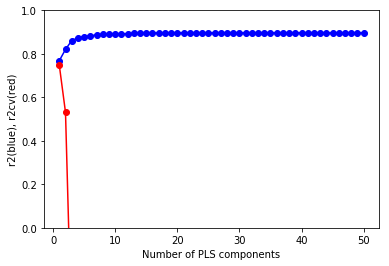

# component_number :  1
fix_regression_model
pls_r
r2: 0.7686251740707944, r2cv: 0.7478933521581443


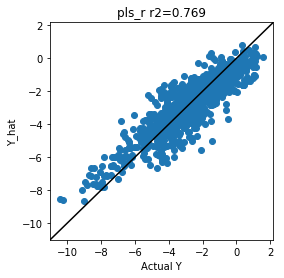

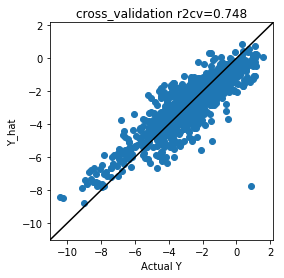

20 <-抽出された- 58
Index(['MolLogP', 'PEOE_VSA6', 'MolMR', 'NumAromaticCarbocycles', 'SMR_VSA10',
       'BertzCT', 'SMR_VSA7', 'NumAromaticRings', 'RingCount', 'VSA_EState10',
       'PEOE_VSA7', 'Kappa2', 'MinPartialCharge', 'EState_VSA3', 'fr_bicyclic',
       'SMR_VSA9', 'EState_VSA8', 'EState_VSA5', 'PEOE_VSA9', 'FractionCSP3'],
      dtype='object')
MolLogP                   2.725720
PEOE_VSA6                 2.364896
MolMR                     2.216357
NumAromaticCarbocycles    1.958443
SMR_VSA10                 1.942918
BertzCT                   1.917830
SMR_VSA7                  1.781575
NumAromaticRings          1.670255
RingCount                 1.666992
VSA_EState10              1.591353
PEOE_VSA7                 1.425211
Kappa2                    1.408880
MinPartialCharge          1.131306
EState_VSA3               1.064150
fr_bicyclic               1.057935
SMR_VSA9                  1.028391
EState_VSA8               0.986414
EState_VSA5               0.946807
PEOE_VSA9       

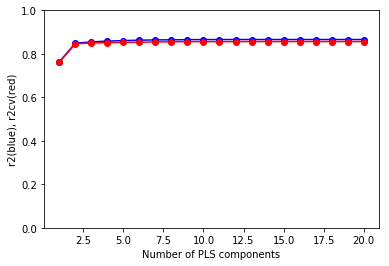

# component_number :  16
fix_regression_model
pls_r
r2: 0.8659135933839692, r2cv: 0.8564612603546555


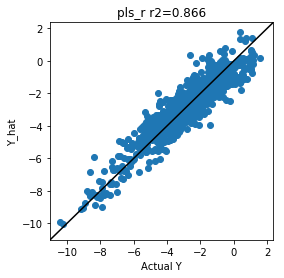

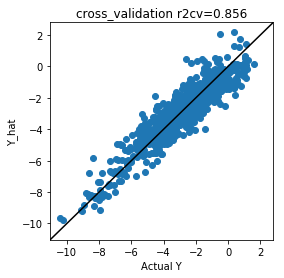

                        standard regression coefficient  \
MolLogP                                       -0.381188   
BertzCT                                       -0.269579   
MinPartialCharge                              -0.200481   
SMR_VSA7                                       0.127855   
PEOE_VSA6                                     -0.124432   
FractionCSP3                                   0.122157   
MolMR                                         -0.115814   
NumAromaticCarbocycles                        -0.112494   
RingCount                                      0.097896   
Kappa2                                        -0.089605   
EState_VSA5                                   -0.076113   
SMR_VSA10                                     -0.066199   
fr_bicyclic                                   -0.061849   
EState_VSA3                                   -0.055245   
SMR_VSA9                                      -0.045919   
VSA_EState10                                  -0.045309 

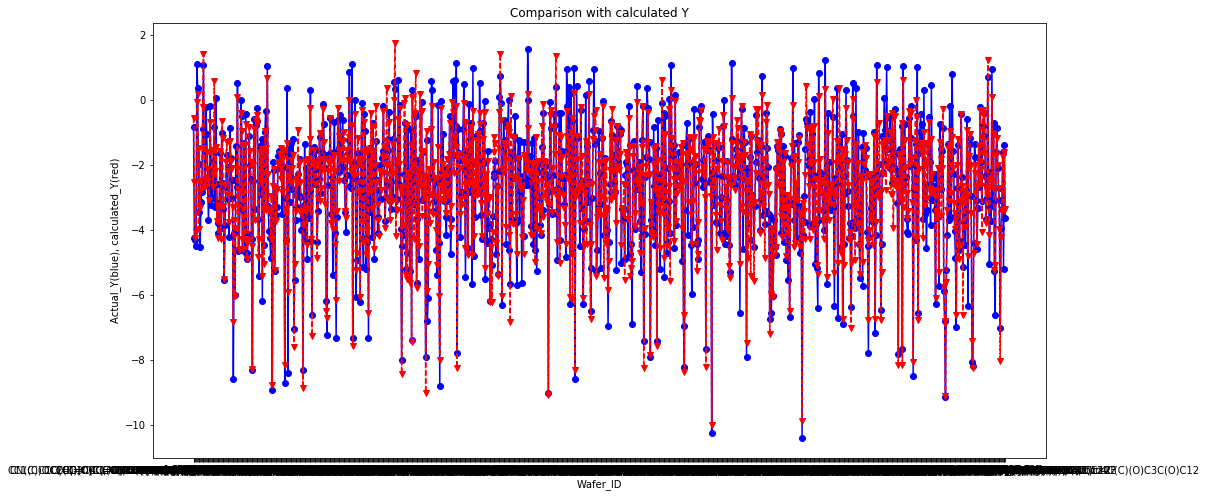

estimate_data : (300, 20)
predict future


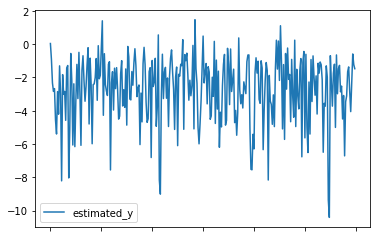

pass rate = 43.667 %
                                                    estimated_y
O=C(O)CCC(=O)O                                         0.038795
Nc1ccccc1O                                            -0.915680
C=CCSS(=O)CC=C                                        -2.331287
C=CCN(CC=C)C(=O)C(Cl)Cl                               -2.837973
CCCCCCCC(=O)OCC                                       -2.669023
CC12CCc3c(ccc4cc(O)ccc34)C1CCC2=O                     -4.554109
OCCN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1              -5.397625
ClC(Cl)(Cl)Cl                                         -2.849467
Cc1cccc2ccccc12                                       -4.205200
COC(=O)c1ccc(OC)cc1                                   -1.303331
O=C(O)COc1ccc(Cl)cc1Cl                                -2.971570
Clc1cccc(-c2cc(Cl)c(Cl)c(Cl)c2Cl)c1Cl                 -8.212125
CCC(=O)c1ccc(N)cc1                                    -1.829354
CCSCc1ccccc1OC(=O)NC                                  -3.015823
COc1cc(Cl)c(Cl)cc1O

In [26]:
if __name__ == '__main__':
    main()